In [1]:
import csv
from pathlib import Path
import re

In [2]:
p_ours_filelist = Path('../data/_filelists/k400/filelist_k400_train_open_all.txt')
with p_ours_filelist.open('r') as f:
    ours_data = [[p, int(length), int(label)] for p, length, label in csv.reader(f, delimiter=' ')]
ours_data[:5]

[['unboxing/VsLP2zBzkho_000297_000307', 300, 35],
 ['cleaning_toilet/nmrrI4xcu2I_000022_000032', 300, 18],
 ['kitesurfing/4U70dPd0ujI_000000_000010', 300, 40],
 ['tango_dancing/s_XqjN0cnIs_000225_000235', 250, 13],
 ['dancing_macarena/-ttWnf0TQY4_000034_000044', 300, 14]]

In [3]:
p_mmaction_filelist = Path('../tools/data/kinetics/kinetics400/annotations/kinetics_train.csv')
with p_mmaction_filelist.open('r') as f:
    reader = csv.reader(f)
    header = next(reader)
    mmaction_data = [[label_name, youtube_id, int(time_start), int(time_end), split] for label_name, youtube_id, time_start, time_end, split in reader]
mmaction_data[:5]

[['testifying', '---QUuC4vJs', 84, 94, 'train'],
 ['eating spaghetti', '--3ouPhoy2A', 20, 30, 'train'],
 ['dribbling basketball', '--4-0ihtnBU', 58, 68, 'train'],
 ['playing tennis', '--56QUhyDQM', 185, 195, 'train'],
 ['tap dancing', '--6q_33gNew', 132, 142, 'train']]

In [4]:
p_video_dir = Path('/data/dataset/kinetics400/videos')
p_video_train_dir = p_video_dir / 'train'
p_all_videos = list(p_video_train_dir.glob('**/*.mp4'))

all_video_ids = [p_video.stem[:-14] for p_video in p_all_videos]  # without clip number (_dddddd_dddddd)

### 겹치는 비디오는 없음
### 없는 거 까면 train set에서만 대충 230개 까임

In [5]:
len(all_video_ids), len(set(all_video_ids))

(231305, 231305)

### K400 파일 이름 구조
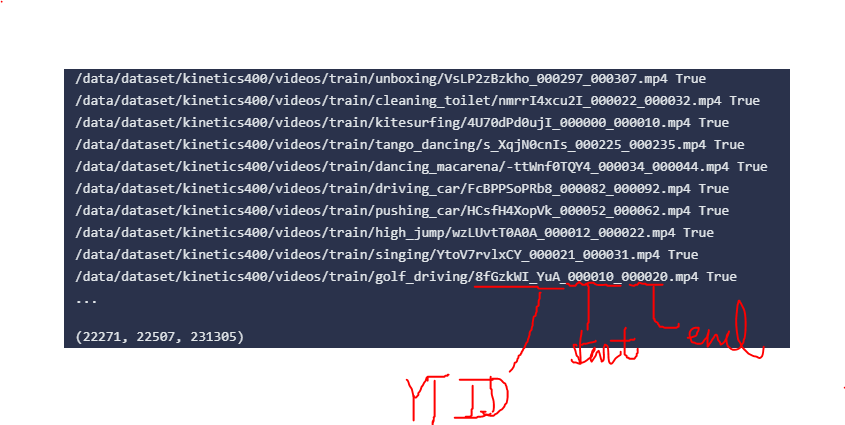

In [6]:
num_avail = 0
for i, (video, _, _) in enumerate(ours_data):
    p_video = (p_video_train_dir / video).with_suffix('.mp4')
    is_file = p_video.is_file()
    num_avail += is_file
    if i < 10:
        print(p_video, is_file)
print('...')
num_avail, len(ours_data), len(p_all_videos)

/data/dataset/kinetics400/videos/train/unboxing/VsLP2zBzkho_000297_000307.mp4 True
/data/dataset/kinetics400/videos/train/cleaning_toilet/nmrrI4xcu2I_000022_000032.mp4 True
/data/dataset/kinetics400/videos/train/kitesurfing/4U70dPd0ujI_000000_000010.mp4 True
/data/dataset/kinetics400/videos/train/tango_dancing/s_XqjN0cnIs_000225_000235.mp4 True
/data/dataset/kinetics400/videos/train/dancing_macarena/-ttWnf0TQY4_000034_000044.mp4 True
/data/dataset/kinetics400/videos/train/driving_car/FcBPPSoPRb8_000082_000092.mp4 True
/data/dataset/kinetics400/videos/train/pushing_car/HCsfH4XopVk_000052_000062.mp4 True
/data/dataset/kinetics400/videos/train/high_jump/wzLUvtT0A0A_000012_000022.mp4 True
/data/dataset/kinetics400/videos/train/singing/YtoV7rvlxCY_000021_000031.mp4 True
/data/dataset/kinetics400/videos/train/golf_driving/8fGzkWI_YuA_000010_000020.mp4 True
...


(22271, 22507, 231305)

### 왜 하나가 읍노...
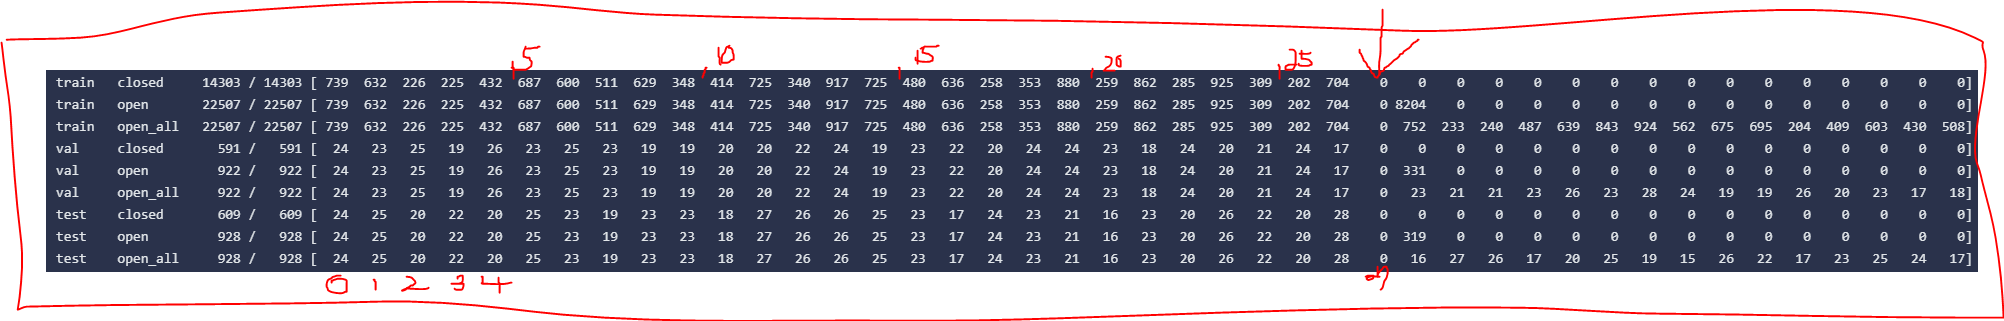

In [7]:
from collections import Counter
import numpy as np

p_video_dir = Path('/data/dataset/kinetics400/videos')
order_split = {'train': 0, 'val': 1, 'test': 2}
order_mode = {'closed': 0, 'open': 1, 'open_all': 2}
p_ours_filelists = list(Path('../data/_filelists/k400').glob('*.txt'))
outputs = [None for _ in range(9)]
num_classes = [28, 28+1, 43]
output_dist = np.zeros((3*3, num_classes[-1]))
for p_ours_filelist in p_ours_filelists:
    if 'stats' in p_ours_filelist.stem: continue
    (split, mode), = re.findall(r'filelist_k400_([a-z]*)_(\w*)', p_ours_filelist.stem)
    p_video_split_dir = p_video_dir / ('val' if split=='test' else split)
    with p_ours_filelist.open('r') as f:
        lines = []
        for i, line in enumerate(csv.reader(f, delimiter=' ')):
            p, _, _ = line
            p_video = (p_video_split_dir / p).with_suffix('.mp4')
            if p_video.is_file() or True:  # val인데 train 폴더 안에 들어있고 이런 거 아님? => ㅇㅇ 아님
                lines.append(line)
        order = 3*order_split[split]+order_mode[mode]
        outputs[order] = f'{split:5}\t{mode:8}   {len(lines):>5d} / {i+1:>5d}'
        label_dist = Counter([int(label) for _, _, label in lines])
        output_dist[order] = [label_dist.get(i, 0) for i in range(43)]

with np.printoptions(linewidth=1000, formatter=dict(float=lambda x: "%4.0f" % x)):
    for i in range(len(outputs)):
        print(outputs[i], end=' ')
        print(output_dist[i][:num_classes[i%3]])

train	closed     14303 / 14303 [ 739  632  226  225  432  687  600  511  629  348  414  725  340  917  725  480  636  258  353  880  259  862  285  925  309  202  704    0]
train	open       22507 / 22507 [ 739  632  226  225  432  687  600  511  629  348  414  725  340  917  725  480  636  258  353  880  259  862  285  925  309  202  704    0 8204]
train	open_all   22507 / 22507 [ 739  632  226  225  432  687  600  511  629  348  414  725  340  917  725  480  636  258  353  880  259  862  285  925  309  202  704    0  752  233  240  487  639  843  924  562  675  695  204  409  603  430  508]
val  	closed       591 /   591 [  24   23   25   19   26   23   25   23   19   19   20   20   22   24   19   23   22   20   24   24   23   18   24   20   21   24   17    0]
val  	open         922 /   922 [  24   23   25   19   26   23   25   23   19   19   20   20   22   24   19   23   22   20   24   24   23   18   24   20   21   24   17    0  331]
val  	open_all     922 /   922 [  24   23   25   1

### 진짜 없는 것 확인 됨
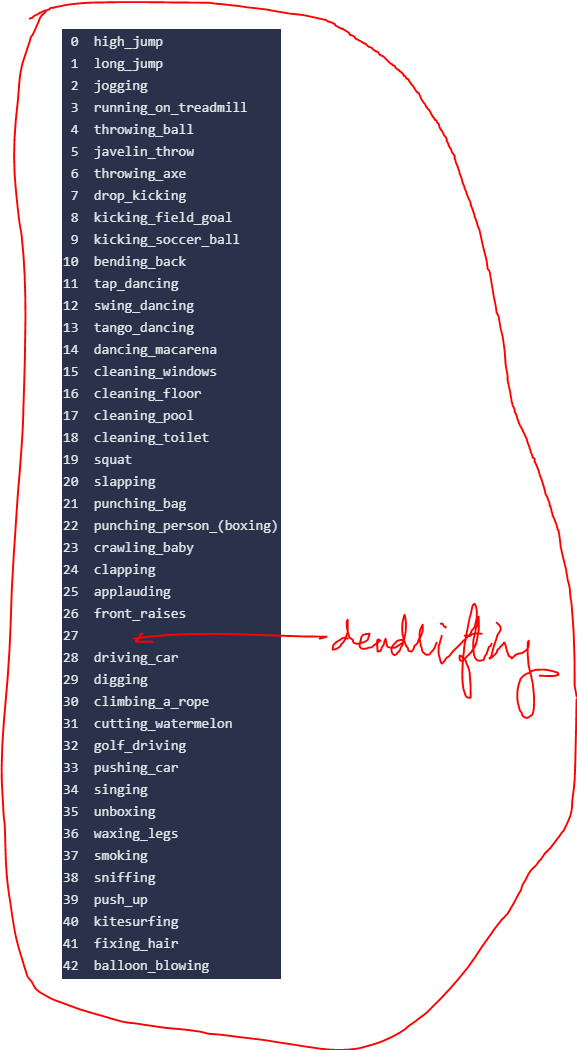

In [8]:
from collections import defaultdict

with p_ours_filelists[6].open('r') as f:
    data = list(csv.reader(f, delimiter=' '))
cdar_labelmap = defaultdict(str)
for p, _, label in data:
    cdar_labelmap[int(label)] = p.split('/')[0]
for l in range(max(cdar_labelmap.keys())+1):
    print(f'{l:2d}  {cdar_labelmap[l]}')

 0  high_jump
 1  long_jump
 2  jogging
 3  running_on_treadmill
 4  throwing_ball
 5  javelin_throw
 6  throwing_axe
 7  drop_kicking
 8  kicking_field_goal
 9  kicking_soccer_ball
10  bending_back
11  tap_dancing
12  swing_dancing
13  tango_dancing
14  dancing_macarena
15  cleaning_windows
16  cleaning_floor
17  cleaning_pool
18  cleaning_toilet
19  squat
20  slapping
21  punching_bag
22  punching_person_(boxing)
23  crawling_baby
24  clapping
25  applauding
26  front_raises
27  
28  driving_car
29  digging
30  climbing_a_rope
31  cutting_watermelon
32  golf_driving
33  pushing_car
34  singing
35  unboxing
36  waxing_legs
37  smoking
38  sniffing
39  push_up
40  kitesurfing
41  fixing_hair
42  balloon_blowing


# 하나 새로 만들자!!
* 각 mmaction split마다
    * 각 data마다
        * 데이터셋에 실제로 있는가?
        * CDAR label에 포함되는가?

### label index 확인

In [9]:
p_k400_labelmap = Path('../tools/data/kinetics/label_map_k400.txt')
with p_k400_labelmap.open('r') as f:
    k400_labelmap = [labelname.replace(' ', '_') for labelname, in csv.reader(f)]  # index to labelname
k400_cdar_labelnames = ['high_jump','long_jump','jogging','running_on_treadmill','throwing_ball','javelin_throw','throwing_axe','drop_kicking','kicking_field_goal','kicking_soccer_ball','bending_back','tap_dancing','swing_dancing','tango_dancing','dancing_macarena','cleaning_windows','cleaning_floor','cleaning_pool','cleaning_toilet','squat','slapping','punching_bag','punching_person_(boxing)','crawling_baby','clapping','applauding','front_raises','deadlifting','driving_car','digging','climbing_a_rope','cutting_watermelon','golf_driving','pushing_car','singing','unboxing','waxing_legs','smoking','sniffing','push_up','kitesurfing','fixing_hair','balloon_blowing']
for i, k400_cdar_label in enumerate(k400_cdar_labelnames):
    if i == 28: print()
    print(f'{i:2d}  {k400_cdar_label:^30}  {k400_labelmap.index(k400_cdar_label):3d}')

 0            high_jump             151
 1            long_jump             182
 2             jogging              168
 3       running_on_treadmill       281
 4          throwing_ball           357
 5          javelin_throw           166
 6           throwing_axe           356
 7           drop_kicking           105
 8        kicking_field_goal        174
 9       kicking_soccer_ball        175
10           bending_back            20
11           tap_dancing            349
12          swing_dancing           342
13          tango_dancing           348
14         dancing_macarena          87
15         cleaning_windows          65
16          cleaning_floor           60
17          cleaning_pool            62
18         cleaning_toilet           64
19              squat               330
20             slapping             314
21           punching_bag           258
22     punching_person_(boxing)     259
23          crawling_baby            77
24             clapping              57


### mmaction split에 있는 data 중 dataset에 없는 애들 거르기
##### 코드 돌아가는 것만 확인하고 node 가서 .py 파일 돌리셈 NAS 개느림, 20분 정도 걸림, NAS로 하면 1시간 걸림

In [10]:
import io
from mmcv.fileio import FileClient
import decord
from typing import Union

def is_mp4_crashed(p_abs_video:Union[str,Path]):
    p_abs_video = str(p_abs_video)
    file_client = FileClient(backend='disk')
    file_obj = io.BytesIO(file_client.get(p_abs_video))
    try:
        container = decord.VideoReader(file_obj, num_threads=1)
    except decord._ffi.base.DECORDError as e:
        is_crashed = True
    except RuntimeError as e:
        if 'Error reading' in str(e):
            is_crashed = True
        else:
            raise e
    else:
        del container
        is_crashed = False
    return is_crashed

have_we_downloaded_test_dataset = False  # False이면 val을 둘로 나눠서 val/test로 쓸 것임

p_video_dir = Path('/data/dataset/kinetics400/videos')
p_mmaction_split_dir = Path('../tools/data/kinetics/kinetics400/annotations')
p_new_filelist_dir = Path('/data/hyogun/repos/haawron_mmaction2/data/_filelists/k400/processed')
splits = ['train', 'val', 'test']
mmaction_class_dict = {}  # valid 한 애들의 class 별 모임의 split 별 모임
invalid_class_dict = {}  # invalid 한 애들의 class 별 모임의 split 별 모임
for split in splits:
    p_new_filelists = [
        p_new_filelist_dir / f'filelist_k400_{split}_closed.txt',
        p_new_filelist_dir / f'filelist_k400_{split}_open.txt',
        p_new_filelist_dir / f'filelist_k400_{split}_open_all.txt',
    ]
    fs = [p.open('w') for p in p_new_filelists]
    writers = [csv.writer(f, delimiter=' ') for f in fs]

    split_of_mmaction = (
        split if have_we_downloaded_test_dataset
        else (
            'val' if split == 'test'
            else split
    ))
    p_mmaction_split = (p_mmaction_split_dir / ('kinetics_' + split_of_mmaction)).with_suffix('.csv')
    p_video_split_dir = p_video_dir / split_of_mmaction
    valid_data_per_class = [[] for _ in range(400)]
    invalid_data_per_class = [[] for _ in range(400)]
    valid_annotation = []
    invalid_annotation = []
    with p_mmaction_split.open('r') as f:
        reader = csv.reader(f)
        header = next(reader)
        for i, line in enumerate(reader):
            if not have_we_downloaded_test_dataset and i % 2 == (1 if split == 'val' else 0):
                # testset이 없으면 둘 중 val을 반반 나눔
                # 정확히 나누려면 코드 좀 많이 고쳐야 되니까 홀짝으로 나눔
                continue
            labelname, youtube_id, t_start, t_end, _ = line
            p_video = p_video_split_dir / labelname / f'{youtube_id}_{int(t_start):06d}_{int(t_end):06d}.mp4'
            if p_video.is_file() and not is_mp4_crashed(p_video):
                valid_annotation.append(line)
                labelname = labelname.replace(' ', '_')
                if labelname in k400_cdar_labelnames:
                    idx = k400_cdar_labelnames.index(labelname)
                    line = [f'{labelname}/{p_video.stem}', 30*(int(t_end)-int(t_start)), idx]
                    if idx < 28:
                        writers[0].writerow(line)
                    writers[1].writerow(line[:-1] + [min(idx, 28)])
                    writers[2].writerow(line)
            else:
                invalid_annotation.append(line)

    for labelname, youtube_id, t_start, t_end, _ in valid_annotation:
        valid_data_per_class[k400_labelmap.index(labelname.replace(' ', '_'))].append(youtube_id)
    for labelname, youtube_id, _, _, _ in invalid_annotation:
        invalid_data_per_class[k400_labelmap.index(labelname.replace(' ', '_'))].append(youtube_id)

    mmaction_class_dict[split] = valid_data_per_class
    invalid_class_dict[split] = invalid_data_per_class

    for f in fs: f.close()

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


KeyboardInterrupt: 

### 최종 label distribution 확인

In [6]:
from pathlib import Path
import csv

new_class_dict = {}
splits = ['train', 'val', 'test']
p_new_filelist_dir = Path('/data/hyogun/repos/haawron_mmaction2/data/_filelists/k400/processed')
k400_cdar_labelnames = ['high_jump','long_jump','jogging','running_on_treadmill','throwing_ball','javelin_throw','throwing_axe','drop_kicking','kicking_field_goal','kicking_soccer_ball','bending_back','tap_dancing','swing_dancing','tango_dancing','dancing_macarena','cleaning_windows','cleaning_floor','cleaning_pool','cleaning_toilet','squat','slapping','punching_bag','punching_person_(boxing)','crawling_baby','clapping','applauding','front_raises','deadlifting','driving_car','digging','climbing_a_rope','cutting_watermelon','golf_driving','pushing_car','singing','unboxing','waxing_legs','smoking','sniffing','push_up','kitesurfing','fixing_hair','balloon_blowing']

for split in splits:
    p_new_filelist = p_new_filelist_dir / f'filelist_k400_{split}_open_all.txt'
    with p_new_filelist.open('r') as f:
        filelist = list(csv.reader(f, delimiter=' '))
        dist = [0] * 43
        for p, length, label in filelist:
            dist[int(label)] += 1
        new_class_dict[split] = dist
for i, k400_cdar_labelname in enumerate(k400_cdar_labelnames):
    if i == 28: print()
    string = '  '.join([f'{new_class_dict[split][i]:3d}' for split in splits])
    print(f'{i:2d}  {k400_cdar_labelname:40}  {string}')

 0  high_jump                                 739   21   27
 1  long_jump                                 632   16   32
 2  jogging                                   226   21   24
 3  running_on_treadmill                      224   22   19
 4  throwing_ball                             432   21   25
 5  javelin_throw                             687   21   27
 6  throwing_axe                              600   24   24
 7  drop_kicking                              511   27   15
 8  kicking_field_goal                        629   17   25
 9  kicking_soccer_ball                       348   18   24
10  bending_back                              414   23   15
11  tap_dancing                               725   27   20
12  swing_dancing                             340   23   25
13  tango_dancing                             917   25   25
14  dancing_macarena                          725   16   28
15  cleaning_windows                          480   24   22
16  cleaning_floor                      

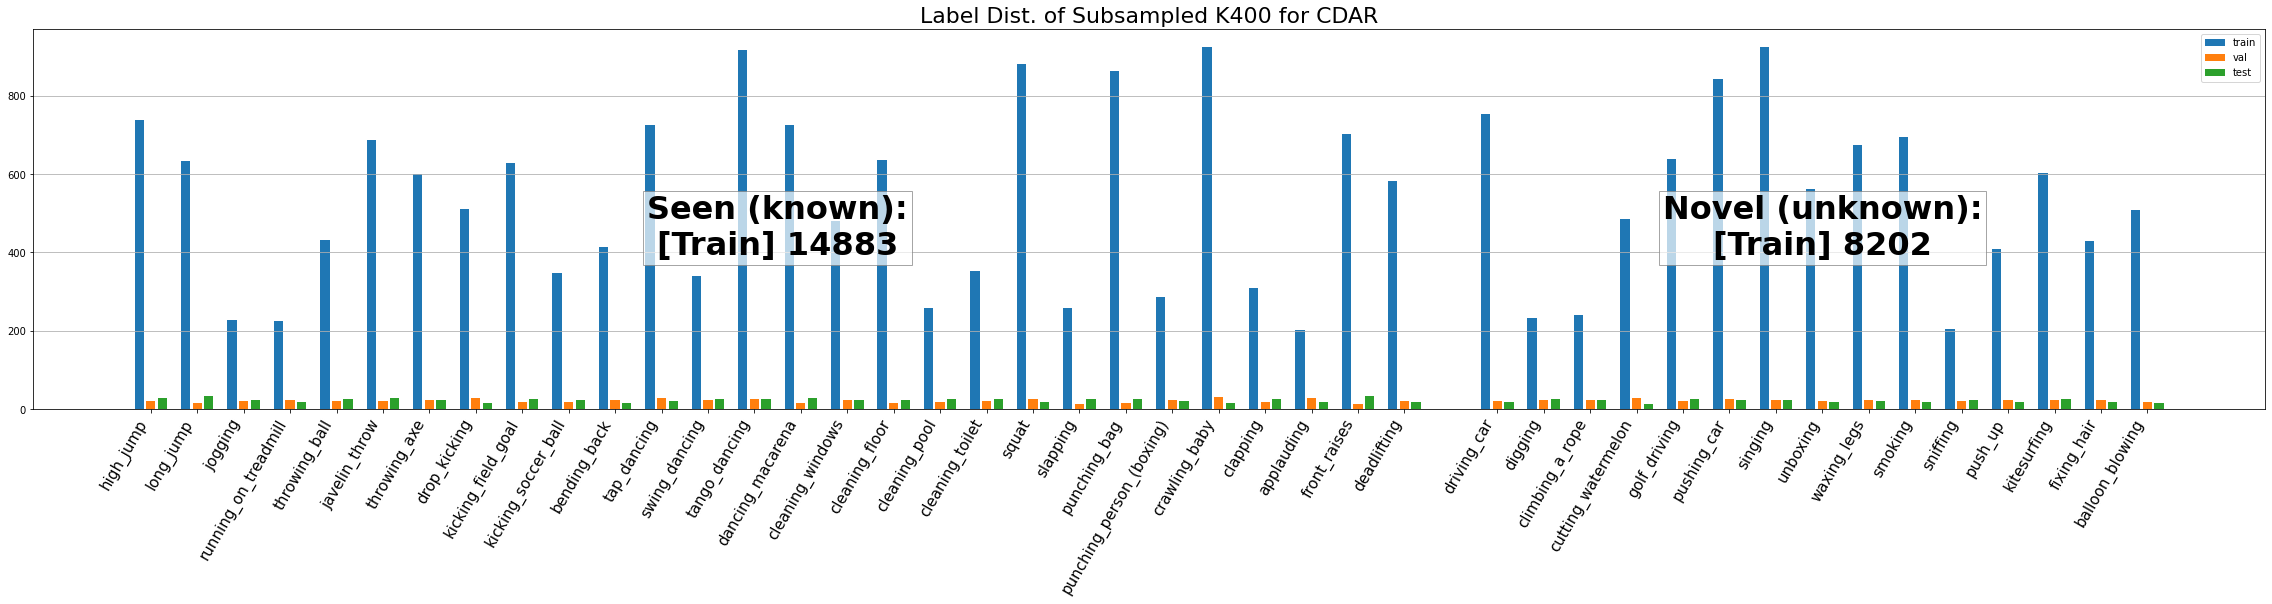

In [8]:
import matplotlib.pyplot as plt
import numpy as np 

plt.figure(figsize=(40,7))
plt.title('Label Dist. of Subsampled K400 for CDAR', fontsize=22)
x = np.arange(28+1+15) * 4
x = np.delete(x, 28)
for i, split in enumerate(splits):
    plt.bar(x+i-1, new_class_dict[split], label=split)
mid1, mid2 = x[:28].mean(), x[28:].mean()
t = plt.text(mid1, max(new_class_dict["train"])/2, f'Seen (known):\n[Train] {sum(new_class_dict["train"][:28])}', ha='center', va='center', fontsize=32, fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='gray'))
t = plt.text(mid2, max(new_class_dict["train"])/2, f'Novel (unknown):\n[Train] {sum(new_class_dict["train"][28:])}', ha='center', va='center', fontsize=32, fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xticks(x, k400_cdar_labelnames, rotation=60, ha='right', va='top', fontsize=15)
plt.grid(axis='y')
plt.legend() 
plt.show() 

In [9]:
label_dist_per_split = np.array([list(map(len, data_per_class)) for _, data_per_class in mmaction_class_dict.items()])
with np.printoptions(linewidth=1000, edgeitems=200):
    print(label_dist_per_split)
label_dist_per_split.sum(axis=1)

NameError: name 'mmaction_class_dict' is not defined